# Measurement noise assessment

In this notebook, we illustrate how to use pyABC with different noise models. For simplicity, we use a simple ODE model of a conversion reaction. For simplicity, we consider an ODE model with a single parameter:

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pyabc
%matplotlib inline

# initialize global random state
np.random.seed(2)

# initial states
init = np.array([1, 0])

# time points
n_time = 10
measurement_times = np.linspace(0, 10, n_time)

def f(y, t0, theta1, theta2=np.exp(-2)):
    """ODE right-hand side."""
    x1, x2 = y
    dx1 = - theta1 * x1 + theta2 * x2
    dx2 =   theta1 * x1 - theta2 * x2
    return dx1, dx2

def model(p: dict):
    """ODE model."""
    sol = sp.integrate.odeint(
             f, init, measurement_times, args=(p["theta1"],))
    return {'X_2': sol[:,1]}

# true parameter
theta_true = {'theta1': 0.08}

# uniform prior distribution
theta1_min, theta1_max = 0.05, 0.12
theta_lims = {'theta1': (theta1_min, theta1_max)}
prior = pyabc.Distribution(
    theta1=pyabc.RV("uniform", theta1_min, theta1_max-theta1_min))

# true noise-free data
true_trajectory = model(theta_true)

# population size
pop_size = 500

/home/yannik/anaconda3/envs/env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/yannik/anaconda3/envs/env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


However, we assume that our measurements are subject to additive Gaussian noise:

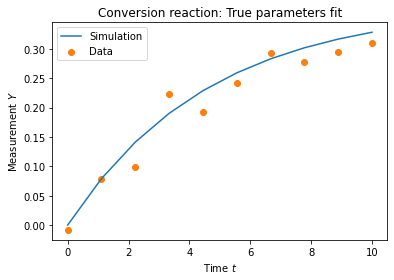

In [2]:
# noise standard deviation
sigma = 0.02

def model_noisy(pars):
    """Add noise to model output"""
    sim = model(pars)
    return {'X_2': sim['X_2'] + sigma * np.random.randn(n_time)}

# the actual observed data
measured_data = model_noisy(theta_true)

# plot data
plt.plot(measurement_times, true_trajectory['X_2'], color="C0",
         label='Simulation')
plt.scatter(measurement_times, measured_data['X_2'],
            color="C1", label='Data')
plt.xlabel('Time $t$')
plt.ylabel('Measurement $Y$')
plt.title('Conversion reaction: True parameters fit')
plt.legend()
plt.show()

## True posterior

For this cute model, we can calculate the actual posterior distribution. The content of this section is not necessary to understand the concept of exact inference and may be skipped.

In [3]:
def normal_dty(y_bar, y, sigma):
    """Uncorrelated multivariate Gaussian density `y_bar ~ N(y, sigma)."""
    y_bar, y, sigma = y_bar.flatten(), y.flatten(), sigma.flatten()
    return np.prod(
        1 / np.sqrt( 2 * np.pi * sigma**2)
        * np.exp( - ( (y_bar - y) / sigma)**2 / 2)
    )

def posterior_unscaled_1d(p):
    """Unscaled posterior density."""
    # simulations and sigmas as arrays
    y = model(p)['X_2'].flatten()
    sigmas = sigma * np.ones(n_time)

    # unscaled likelihood
    likelihood_val = normal_dty(measured_data['X_2'], y, sigmas)

    # prior
    prior_val = prior.pdf(p)

    return likelihood_val * prior_val

# the integral needs to be 1
posterior_normalization = sp.integrate.quad(
    lambda x: posterior_unscaled_1d({'theta1': x}),
    *theta_lims['theta1'])[0]

def posterior_scaled_1d(p):
    """Posterior over theta with integral 1."""
    return posterior_unscaled_1d(p) / posterior_normalization

# calculate posterior on grid values
xs = np.linspace(*theta_lims['theta1'], 200)
true_fvals = [posterior_scaled_1d({'theta1': x}) for x in xs]

## Ignoring noise

In the notebook "Ordinary Differential Equations: Conversion Reaction", this model is used without accounting for a noise model, which is strictly speaking not correct. In this case, we get the following result:

In [4]:
def distance(simulation, data):
    """Here we use an l2 distance."""
    return np.sum((data["X_2"] - simulation["X_2"])**2)

abc = pyabc.ABCSMC(model, prior, distance, population_size=pop_size)
abc.new(pyabc.create_sqlite_db_id(), measured_data)
history_ignore = abc.run(max_nr_populations=7)

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-01-23 17:38:06.971636, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.020631260338241815
INFO:ABC:t: 0, eps: 0.020631260338241815.
INFO:ABC:Acceptance rate: 500 / 995 = 5.0251e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 0.008290796191877036.
INFO:ABC:Acceptance rate: 500 / 1049 = 4.7664e-01, ESS=4.9627e+02.
INFO:ABC:t: 2, eps: 0.00539613641136926.
INFO:ABC:Acceptance rate: 500 / 1050 = 4.7619e-01, ESS=4.9811e+02.
INFO:ABC:t: 3, eps: 0.004678806288403147.
INFO:ABC:Acceptance rate: 500 / 972 = 5.1440e-01, ESS=4.9995e+02.
INFO:ABC:t: 4, eps: 0.004514515095967765.
INFO:ABC:Acceptance rate: 500 / 1046 = 4.7801e-01, ESS=4.9839e+02.
INFO:ABC:t: 5, eps: 0.004476985905128385.
INFO:ABC:Acceptance rate: 500 / 1012 = 4.9407e-01, ESS=4.9952e+02.
INFO:ABC:t: 6, eps: 0.004465071006829492.
INFO:ABC:Acceptance rate: 500 / 1098 = 4.5537e-01, ESS=4.9714e+02.
INFO:py

As one can see in the below plot, this converges to a point estimate as $\varepsilon\rightarrow \varepsilon_\text{min}>0$, and does not correctly represent the posterior. In particular, in general this point estimate will not capture the correct parameter value (indicated by the grey line). Furthermore, its exact location will depend on the distance function -- using an l1 instead of the here used l2 distance will result in a different peak (namely the MLE of an assumed Laplace noise model).

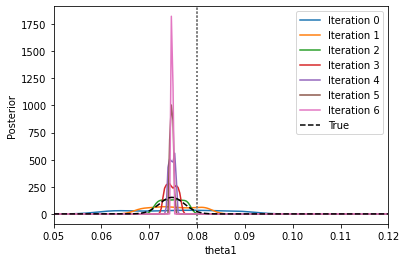

In [5]:
_, ax = plt.subplots()
for t in range(history_ignore.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history_ignore, x="theta1", t=t, refval=theta_true, refval_color='grey',
        xmin=theta1_min, xmax=theta1_max, numx=200, ax=ax, label=f"Iteration {t}")
ax.plot(xs, true_fvals, color='black', linestyle='--', label="True")
ax.legend()
plt.show()

## Add noise to the model output

To correctly account for noise, there are essentially two possibilities: Firstly, we can use the noisified model output:

In [6]:
abc = pyabc.ABCSMC(model_noisy, prior, distance, population_size=pop_size)
abc.new(pyabc.create_sqlite_db_id(), measured_data)
history_noisy_output = abc.run(max_nr_populations=9)

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=2, start_time=2021-01-23 17:38:19.480138, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.026478514861444723
INFO:ABC:t: 0, eps: 0.026478514861444723.
INFO:ABC:Acceptance rate: 500 / 1042 = 4.7985e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 0.013007977767072944.
INFO:ABC:Acceptance rate: 500 / 1055 = 4.7393e-01, ESS=4.9884e+02.
INFO:ABC:t: 2, eps: 0.009018030859295232.
INFO:ABC:Acceptance rate: 500 / 1326 = 3.7707e-01, ESS=4.6569e+02.
INFO:ABC:t: 3, eps: 0.007122876973940274.
INFO:ABC:Acceptance rate: 500 / 2022 = 2.4728e-01, ESS=3.6626e+02.
INFO:ABC:t: 4, eps: 0.00581756989732515.
INFO:ABC:Acceptance rate: 500 / 3428 = 1.4586e-01, ESS=3.9840e+02.
INFO:ABC:t: 5, eps: 0.004730491492082362.
INFO:ABC:Acceptance rate: 500 / 6573 = 7.6069e-02, ESS=4.4793e+02.
INFO:ABC:t: 6, eps: 0.003991344108201219.
INFO:ABC:Acceptance rate: 500 / 12630 = 3.9588e-02, ESS=4.1430e+02.
INFO

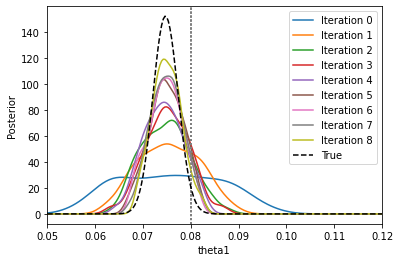

In [7]:
_, ax = plt.subplots()
for t in range(history_noisy_output.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history_noisy_output, x="theta1", t=t,
        refval=theta_true, refval_color='grey',
        xmin=theta1_min, xmax=theta1_max, ax=ax, numx=200, label=f"Iteration {t}")
ax.plot(xs, true_fvals, color='black', linestyle='--', label="True")
ax.legend()

This curve is much broader and closer to the correct posterior, approaching it gradually. The epsilon thresholds converge to zero $\varepsilon\rightarrow 0$, however for $\varepsilon>0$ there remains a slight overestimation of the uncertainty which only gradually fades when decreasing $\varepsilon$ further.

## Modify the acceptance step

Secondly, we can alternatively use the non-noisy model, but adjust the acceptance step:

In [8]:
acceptor = pyabc.StochasticAcceptor()
kernel = pyabc.IndependentNormalKernel(var=sigma**2)
eps = pyabc.Temperature()

abc = pyabc.ABCSMC(model, prior, kernel, eps=eps, acceptor=acceptor,
                   population_size=pop_size)
abc.new(pyabc.create_sqlite_db_id(), measured_data)
history_acceptor = abc.run(max_nr_populations=10)

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=3, start_time=2021-01-23 17:39:33.258855, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:ABC:t: 0, eps: 10.459502700801611.
INFO:ABC:Acceptance rate: 500 / 1594 = 3.1368e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.3126642844096381.
INFO:ABC:Acceptance rate: 500 / 1720 = 2.9070e-01, ESS=4.9810e+02.
INFO:ABC:t: 2, eps: 1.0.
INFO:ABC:Acceptance rate: 500 / 727 = 6.8776e-01, ESS=3.5506e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=3, start_time=2021-01-23 17:39:33.258855, end_time=2021-01-23 17:39:43.841631)>


We use a `pyabc.StochasticAcceptor` for the acceptor, replacing the default `pyabc.UniformAcceptor`, in order to accept when

$$\frac{\pi(D|y,\theta)}{c}\geq[0,1],$$
    
where $\pi(D|y,\theta)$ denotes the distribution of noisy data $D$ given non-noisy model output $y$ and parameters $\theta$. Here, we use a `pyabc.IndependentNormalKernel` in place of a `pyabc.Distance` to capture the normal noise $\pi(D|y,\theta)\sim\mathcal{N}(D|y,\theta,\sigma)$. Also other noise models are possible, including Laplace or binomial noise. In place of the `pyabc.Epsilon`, we employ a `pyabc.Temperature` which implements schemes to decrease a temperature $T\searrow 1$, s.t. in iteration $t$ we sample from

$$\pi(\theta,y|D) \propto \pi(D|y,\theta)^{1/T_t}p(y|\theta)\pi(\theta),$$

where $p(y|\theta)$ denotes the model output likelihood, and $\pi(\theta)$ the parameters prior.

Each of acceptor, kernel and temperature offers various configuration options, however the default parameters have shown to be quite stable already.

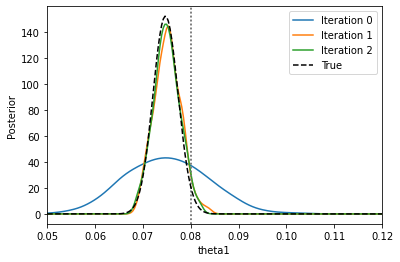

In [9]:
_, ax = plt.subplots()
for t in range(history_acceptor.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history_acceptor, x="theta1", t=t,
        refval=theta_true, refval_color='grey',
        xmin=theta1_min, xmax=theta1_max,
        ax=ax, numx=200, label=f"Iteration {t}")
ax.plot(xs, true_fvals, color='black', linestyle='--', label="True")
ax.legend()
plt.show()

We see that we get a similar posterior distribution as with the noisy output. It matches the true posterior better actually, indicating that already for this simple problem, standard ABC has a hard time reproducing the posterior. Moreover, the posterior is obtained at a much lower computational cost, as the below plot shows:

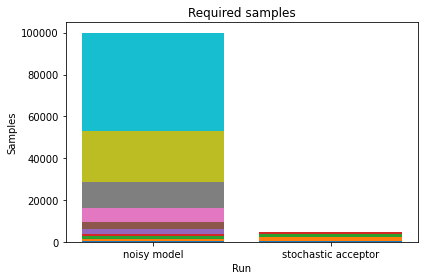

In [10]:
histories = [history_noisy_output, history_acceptor]
labels = ["noisy model", "stochastic acceptor"]

pyabc.visualization.plot_sample_numbers(histories, labels)
plt.show()

Thus, the stochastic acceptor is the method of choice for exact inference. Note that for practical applications it requires in general more simulations than inference without a, or effectively thus with a uniform, noise model. For further details please consult the API documentation and the mentioned manuscript.

## Estimate noise parameters

Our formulation of the modified acceptance step allows the noise model to be parameter-dependent (so does in theory also the noisified model output). Thus one can estimate parameters like e.g. the standard deviation of Gaussian noise on-the-fly.

Parameters are often estimated on a logarithmic scale if fold changes are of interest. We show this here exemplarily with the example of the standard deviation of a normal noise kernel:

In [11]:
theta_true_var = {'theta1': theta_true['theta1'],
                  'std': np.log10(sigma)}

std_min, std_max = np.log10([0.002, 1])
theta_lims_var = {'theta1': (theta1_min, theta1_max),
                  'std': (std_min, std_max)}

prior = pyabc.Distribution(
    theta1=pyabc.RV("uniform", theta1_min, theta1_max-theta1_min),
    std=pyabc.RV("uniform", std_min, std_max-std_min))

Also in this scenario, we can calculate for comparison the true posterior:

In [12]:
%%time

def posterior_unscaled(p):
    """Unscaled posterior with parameter-dependent noise levels."""
    # simulations and sigmas as arrays
    y = model(p)['X_2']
    sigma = 10**p['std'] * np.ones(n_time)

    # unscaled likelihood
    likelihood_val = normal_dty(measured_data['X_2'], y, sigma)

    # prior
    prior_val = prior.pdf(p)

    return likelihood_val * prior_val

# calculate posterior normalization
posterior_normalization = None
# comment out this line to recompute the normalization
posterior_normalization = 382843631.1961108
if posterior_normalization is None:
    posterior_normalization = sp.integrate.dblquad(
        lambda std, theta1: posterior_unscaled({'theta1': theta1, 'std': std}),
        *theta_lims_var['theta1'],
        lambda theta1: std_min, lambda theta1: std_max, epsabs=1e-4)[0]
    print(posterior_normalization)

def posterior_scaled(p):
    """Normalized posterior."""
    return posterior_unscaled(p) / posterior_normalization

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 10.7 µs


We are interested in the marginal densities w.r.t. theta1 and std:

In [13]:
%%time

def marg_theta1(theta1):
    """Posterior marginal w.r.t. theta1."""
    return sp.integrate.quad(
        lambda std: posterior_scaled({'theta1': theta1, 'std': std}),
        *theta_lims_var['std'])[0]

def marg_std(std):
    """Posterior marginal w.r.t. std."""
    return sp.integrate.quad(
        lambda theta1: posterior_scaled({'theta1': theta1, 'std': std}),
        *theta_lims_var['theta1'])[0]

# calculate the densities on a grid

theta1s = np.linspace(*theta_lims_var['theta1'], 100)
vals_theta1 = [marg_theta1(theta1) for theta1 in theta1s]

stds = np.linspace(*theta_lims_var['std'], 100)
vals_std = [marg_std(std) for std in stds]

CPU times: user 18.1 s, sys: 13.1 ms, total: 18.1 s
Wall time: 18.2 s


The actual implementation of exact inference with estimated variance is as follows:

The arameter-dependent noise model is specified by passing a function to the kernel, which takes the parameters and returns an array of variances corresponding to the data. This is currently implemented for the `pyabc.IndependentNormalKernel`, `pyabc.IndependentLaplaceKernel`, `pyabc.BinomialKernel`.

In [14]:
def var(p):
    """Parameterized variance function. Note `var = std**2`."""
    return 10**(2*p['std']) * np.ones(n_time)

acceptor = pyabc.StochasticAcceptor()
# pass variance function to kernel
kernel = pyabc.IndependentNormalKernel(var=var)
eps = pyabc.Temperature()

abc = pyabc.ABCSMC(model, prior, kernel, eps=eps, acceptor=acceptor,
                   population_size=pop_size)
abc.new(pyabc.create_sqlite_db_id(), measured_data)
history_acceptor_var = abc.run(max_nr_populations=6)

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=4, start_time=2021-01-23 17:40:02.796163, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:ABC:t: 0, eps: 17.532489163648943.
INFO:ABC:Acceptance rate: 500 / 1780 = 2.8090e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 9.007988213687888.
INFO:ABC:Acceptance rate: 500 / 1769 = 2.8265e-01, ESS=4.4470e+02.
INFO:ABC:t: 2, eps: 5.199611037073896.
INFO:ABC:Acceptance rate: 500 / 1900 = 2.6316e-01, ESS=3.3756e+02.
INFO:ABC:t: 3, eps: 3.0013310736551353.
INFO:ABC:Acceptance rate: 500 / 2075 = 2.4096e-01, ESS=3.9180e+02.
INFO:ABC:t: 4, eps: 1.7324350128230308.
INFO:ABC:Acceptance rate: 500 / 1819 = 2.7488e-01, ESS=4.1586e+02.
INFO:ABC:t: 5, eps: 1.0.
INFO:ABC:Acceptance rate: 500 / 1659 = 3.0139e-01, ESS=4.1730e+02.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=4, start_time=2021-01-23 17:40:02.796163, end_time=2021-01-23 17:40:30.680442)>


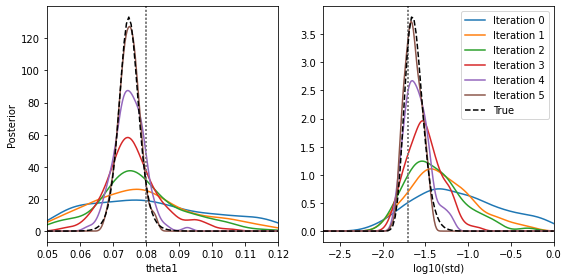

In [15]:
fig, ax = plt.subplots(1, 2)
for t in range(history_acceptor_var.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history_acceptor_var, x="theta1", t=t,
        refval=theta_true_var, refval_color='grey',
        xmin=theta1_min, xmax=theta1_max,
        ax=ax[0], numx=200, label=f"Iteration {t}")
    pyabc.visualization.plot_kde_1d_highlevel(
        history_acceptor_var, x="std", t=t,
        refval=theta_true_var, refval_color='grey',
        xmin=std_min, xmax=std_max,
        ax=ax[1], numx=200, label=f"Iteration {t}")
ax[1].set_xlabel("log10(std)")
ax[1].set_ylabel(None)

ax[0].plot(theta1s, vals_theta1, color='black', linestyle='--', label="True")
ax[1].plot(stds, vals_std, color='black', linestyle='--', label="True")

ax[1].legend()
fig.set_size_inches((8, 4))
fig.tight_layout()
plt.show()

We see that we are able to estimate both parameters quite reasonably (the exact details of course depending on the data and model), they fit to the true posteriors. We omit the comparison in the standard approach with parameter-dependent noise added to the model output, as this performs inferior. It can be trivially implemented.

Fur further aspects, see also [this notebook](https://github.com/yannikschaelte/Study-ABC-Noise/blob/master/study_abc_noise/estimate_noise_parameters/gaussian.ipynb) of the underlying study.